/home/asr/miniconda3/envs/tabenv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.47956 | test_accuracy: 0.68148 |  0:00:00s
epoch 1  | loss: 0.38069 | test_accuracy: 0.56827 |  0:00:01s
epoch 2  | loss: 0.36328 | test_accuracy: 0.71299 |  0:00:01s
epoch 3  | loss: 0.34968 | test_accuracy: 0.74704 |  0:00:01s
epoch 4  | loss: 0.34641 | test_accuracy: 0.78463 |  0:00:02s
epoch 5  | loss: 0.34353 | test_accuracy: 0.80608 |  0:00:02s
epoch 6  | loss: 0.34101 | test_accuracy: 0.8262  |  0:00:03s
epoch 7  | loss: 0.34124 | test_accuracy: 0.84091 |  0:00:03s
epoch 8  | loss: 0.33879 | test_accuracy: 0.84422 |  0:00:04s
epoch 9  | loss: 0.3363  | test_accuracy: 0.84544 |  0:00:04s
epoch 10 | loss: 0.33674 | test_accuracy: 0.84809 |  0:00:05s
epoch 11 | loss: 0.33443 | test_accuracy: 0.84754 |  0:00:05s
epoch 12 | loss: 0.33504 | test_accuracy: 0.84555 |  0:00:05s
epoch 13 | loss: 0.33492 | test_accuracy: 0.84865 |  0:00:06s
epoch 14 | loss: 0.33408 | test_accuracy: 0.84544 |  0:00:06s
epoch 15 | loss: 0.3343  | test_accuracy: 0.84666 |  0:00:07s
epoch 16

/home/asr/miniconda3/envs/tabenv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Final Results
Test Accuracy: 0.8494195688225539
Test F1 Score: 0.6558868115209702


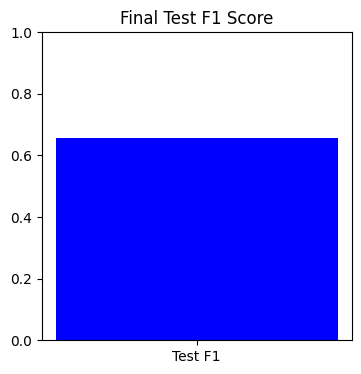

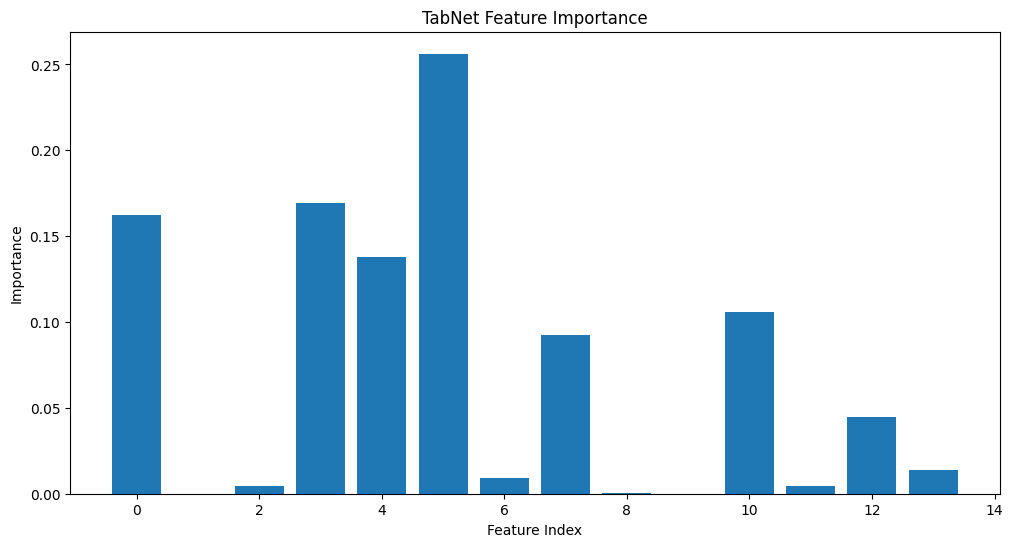

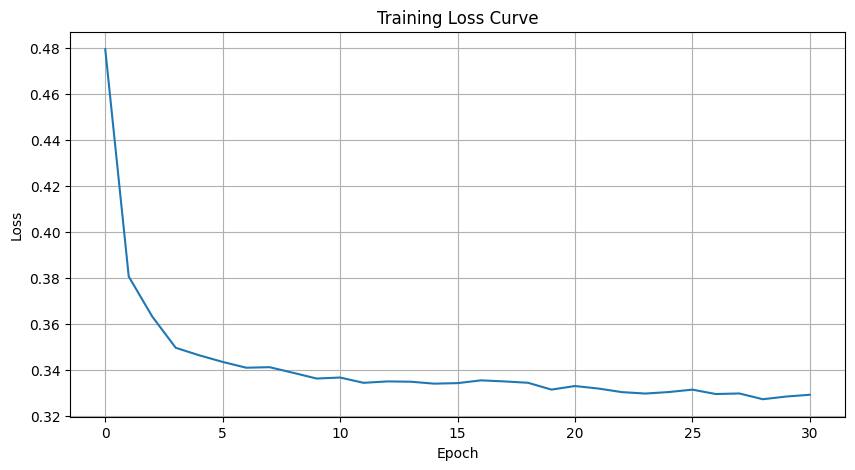

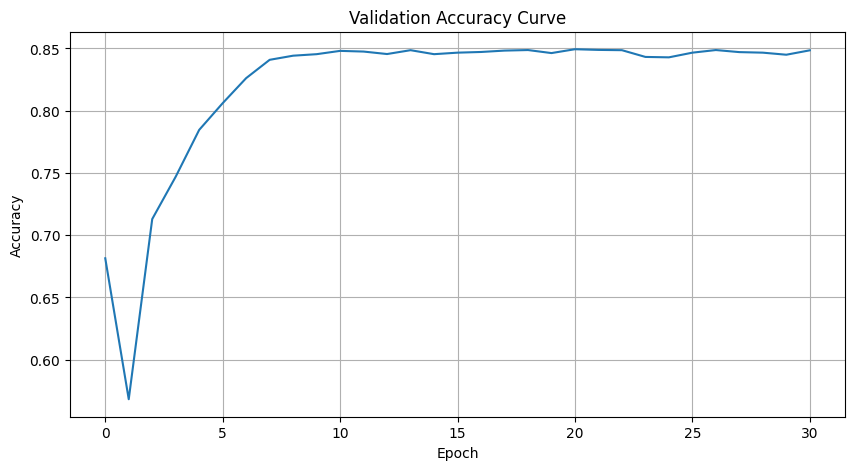

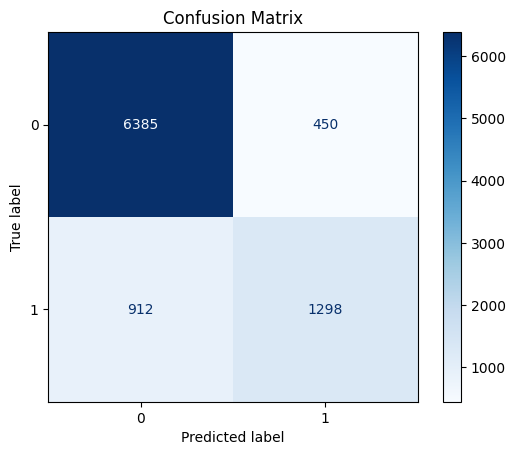


Explain Matrix Shape: (9045, 14)
Number of returned items in masks: 3
Mask 0 is not a valid mask (type=<class 'int'>)
Mask 1 is not a valid mask (type=<class 'int'>)
Mask 2 is not a valid mask (type=<class 'int'>)

No valid masks returned by TabNet version.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# ============================================
# 1) Download Data
# ============================================

train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

columns = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

df_train = pd.read_csv(train_url, header=None, names=columns, skipinitialspace=True)
df_test  = pd.read_csv(test_url, header=0, names=columns, skiprows=1, skipinitialspace=True)

# Clean income strings
df_train["income"] = df_train["income"].str.replace(".", "", regex=False).str.strip()
df_test["income"]  = df_test["income"].str.replace(".", "", regex=False).str.strip()

# ============================================
# 2) Remove rows with missing '?'
# ============================================

df_train.replace("?", pd.NA, inplace=True)
df_test.replace("?", pd.NA, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# ============================================
# 3) Combine train + test for encoding
# ============================================

df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

# ============================================
# 4) Label Encoding for all categorical columns
# ============================================

df_encoded = df.copy()
for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

# ============================================
# 5) Prepare X, y
# ============================================

X = df_encoded.drop(columns=["income"]).values
y = df_encoded["income"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# 6) Train TabNet Model with DEFAULT parameters
# ============================================

clf = TabNetClassifier() 

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"]
)

# ============================================
# 7) Predictions
# ============================================

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("\n=======================")
print("Final Results")
print("=======================")
print("Test Accuracy:", acc)
print("Test F1 Score:", f1)

# ============================================
# 8) Plot F1 Score
# ============================================

plt.figure(figsize=(4,4))
plt.bar(["Test F1"], [f1], color="blue")
plt.ylim(0, 1)
plt.title("Final Test F1 Score")
plt.show()

# ============================================
# 9) Feature Importances
# ============================================

feature_importances = clf.feature_importances_

plt.figure(figsize=(12,6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.title("TabNet Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# ============================================
# 10) Training Loss Curve
# ============================================

plt.figure(figsize=(10,5))
plt.plot(clf.history["loss"])
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ============================================
# 11) Accuracy Curve
# ============================================

plt.figure(figsize=(10,5))
plt.plot(clf.history["test_accuracy"])
plt.title("Validation Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ============================================
# 12) Confusion Matrix
# ============================================

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ============================================
# 13) Extract TabNet Masks Safely
# ============================================

explain_matrix, masks = clf.explain(X_test)

print("\nExplain Matrix Shape:", explain_matrix.shape)
print("Number of returned items in masks:", len(masks))

valid_masks = []

for i, m in enumerate(masks):
    if isinstance(m, np.ndarray):
        print(f"Mask {i} shape:", m.shape)
        valid_masks.append(m)
    else:
        print(f"Mask {i} is not a valid mask (type={type(m)})")

if len(valid_masks) == 0:
    print("\nNo valid masks returned by TabNet version.")
else:
    plt.figure(figsize=(12,4))
    plt.imshow(valid_masks[0], aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.title("TabNet First Valid Mask")
    plt.xlabel("Features")
    plt.ylabel("Samples")
    plt.show()